In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pathlib
from debater_python_api.api.debater_api import DebaterApi

In [2]:
#%run ../milestone2/milestone2.ipynb

### 1. Load the API key and create a term wikifier client

In [3]:
apikey_path = pathlib.Path("../APIkey.txt")
api_key = apikey_path.read_text().strip()

In [4]:
debater_api = DebaterApi(apikey=api_key)

In [5]:
term_wikifier_client = debater_api.get_term_wikifier_client()

 ### 2. Reload the dataframe

In [6]:
df_merge = pd.read_csv("df_merge.csv")
df_merge.head()

,kp,sentence_text,match_score,comment_id,sentence_id,sents_in_comment,span_start,span_end,num_tokens,argument_quality,id,id_description,medical_specialty_new
0,none,The patient is a 1-year-old male with a his...,0.0,1220,0,1,0,157,26,0.650918,1220,1114,Pediatrics - Neonatal
1,none,"At the time of discharge, the patient had im...",0.0,577,0,1,0,53,9,0.442226,577,595,General Medicine
2,none,CO2 insufflation was done to a maximum press...,0.0,1591,0,1,0,121,22,0.492457,1591,1304,Gastroenterology
3,none,"Intrauterine pregnancy of 39 weeks, Herpes s...",0.0,1302,0,1,0,257,34,0.630517,1302,1160,Obstetrics / Gynecology
4,none,"L1 laminotomy, microdissection, retrieval of...",0.0,1100,0,1,0,161,20,0.588591,1100,1036,Neurosurgery


### 3. Define a function that uses the term wikifier to map from a medical transcription in the dataset to a set of mentions in Wikipedia

In [7]:
#Gives a list of terms (in wikipedia) associated with each of the texts supplied
def get_sentence_to_mentions(sentences_texts):
    mentions_list = term_wikifier_client.run(sentences_texts)
    sentence_to_mentions = {}

    for sentence_text, mentions in zip(sentences_texts, mentions_list):
        sentence_to_mentions[sentence_text] = set([
            mention["concept"]["title"]
            for mention in mentions
        ])
    
    return sentence_to_mentions

In [8]:
#df_merge["kp"].unique()

In [9]:
#df_merge["sentence_text"][df_merge["kp"] == ' No evidence of polyps or malignancy.']

In [10]:
#stm = get_sentence_to_mentions(
#    df_merge["sentence_text"][df_merge["kp"] == ' No evidence of polyps or malignancy.'].values)

In [11]:
#stm

### 4. Use this function to tally the references in wikipedia for each key point from the KPA

In [12]:
from collections import Counter

terms = {}

for kp in set(df_merge["kp"].values):
    sentence_to_mentions = get_sentence_to_mentions(
        df_merge["sentence_text"][df_merge["kp"] == kp].values
    )
    
    all_mentions = [
        mention
        for sentence in sentence_to_mentions
        for mention in sentence_to_mentions[sentence]
    ]
    
    term_count = dict(Counter(all_mentions))
    
    if "History" in term_count.keys():
        term_count.pop("History")
   
    terms[kp] = term_count

TermWikifierClient: 100%|███████████████████████| 26/26 [00:00<00:00, 36.97it/s]


In [13]:
#Dump the terms dictionary to a json file
import json

with open("terms.json", "w") as fp:
    json.dump(terms, fp)

In [22]:
for k in terms:
    print(k)

 Microinvasive carcinoma of the cervix.
none
 Hemoptysis and history of lung cancer
 Cognitive linguistic impairment secondary to stroke
 No evidence of polyps or malignancy.
 Lumbar muscle strain and chronic back pain
 Lumbar epidural steroid injection for lumbar radiculopathy.
 Brachytherapy, iodine-125 seed implantation, and cystoscopy.
 Cerebral palsy, worsening seizures
 Enlarged fibroid uterus, hypermenorrhea, and secondary anemia
 No complications were encountered throughout the procedure.
 Congestive heart failure, stable on current regimen
 Hematemesis in a patient with longstanding diabetes
 Sepsis due to urinary tract infection.
 This patient has reoccurring ingrown infected toenails.
 Clinical correlation is recommended.
 Routine colorectal cancer screening
 Risk factors for coronary heart disease.
 Palpitations, possibly related to anxiety
 Possible inflammatory bowel disease
 Unilateral transpedicular T11 vertebroplasty.


### 5. Display the analysis for one diagnosis

In [14]:
df_check = pd.DataFrame(
    list(terms[" Palpitations, possibly related to anxiety"].items()),
    columns = ["Term", "Count"],
).sort_values(by="Count", ascending=False)

df_check.head(10)

,Term,Count
0,Anxiety,3
8,Patient,2
11,Hypertension,1
19,Reduced affect display,1
18,Work-up (chemistry),1
17,Hospital,1
16,Mouth,1
15,Probability,1
14,Amnesia,1
13,Psychological stress,1


### 6. Remove rows with key point 'none' and compare the size of key point clusters

In [15]:
df_clean = df_merge[df_merge["kp"] != "none"]
#df_clean["kp"].value_counts()
df_clean.head()

,kp,sentence_text,match_score,comment_id,sentence_id,sents_in_comment,span_start,span_end,num_tokens,argument_quality,id,id_description,medical_specialty_new
342,Possible inflammatory bowel disease,Possible inflammatory bowel disease,1.000000,1924,0,1,0,36,4,0.617659,1924,1470,Gastroenterology
343,Possible inflammatory bowel disease,"Comprehensive Evaluation - Diabetes, hyperten...",0.999734,3083,0,1,0,91,9,0.620602,3083,2235,General Medicine
344,Possible inflammatory bowel disease,"Gastroesophageal reflux disease, hiatal herni...",0.999734,1264,0,1,0,69,7,0.726280,1264,1139,Gastroenterology
345,Possible inflammatory bowel disease,"Patient with a diagnosis of pancreatitis, dev...",0.999733,777,0,1,0,127,18,0.609229,777,809,Nephrology
346,Possible inflammatory bowel disease,"Colonoscopy due to rectal bleeding, constipat...",0.999732,812,0,1,0,105,14,0.656341,812,846,Gastroenterology


### 7. Visualize the relative frequency of key points grouped by medilal speciality, the distribution of medical specialities for each key point, and the top 10 terms from wikipedia for each key point

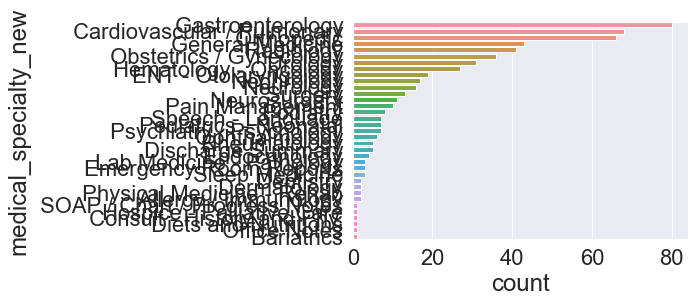

In [16]:
import seaborn as sns

#Frequency of key points grouped by medical speciality
sns.set(rc = { "figure.figsize": (20, 14) }, font_scale=2)
sns.countplot(
    y="medical_specialty_new",
    data=df_clean,
    order=df_clean["medical_specialty_new"].value_counts().index
);

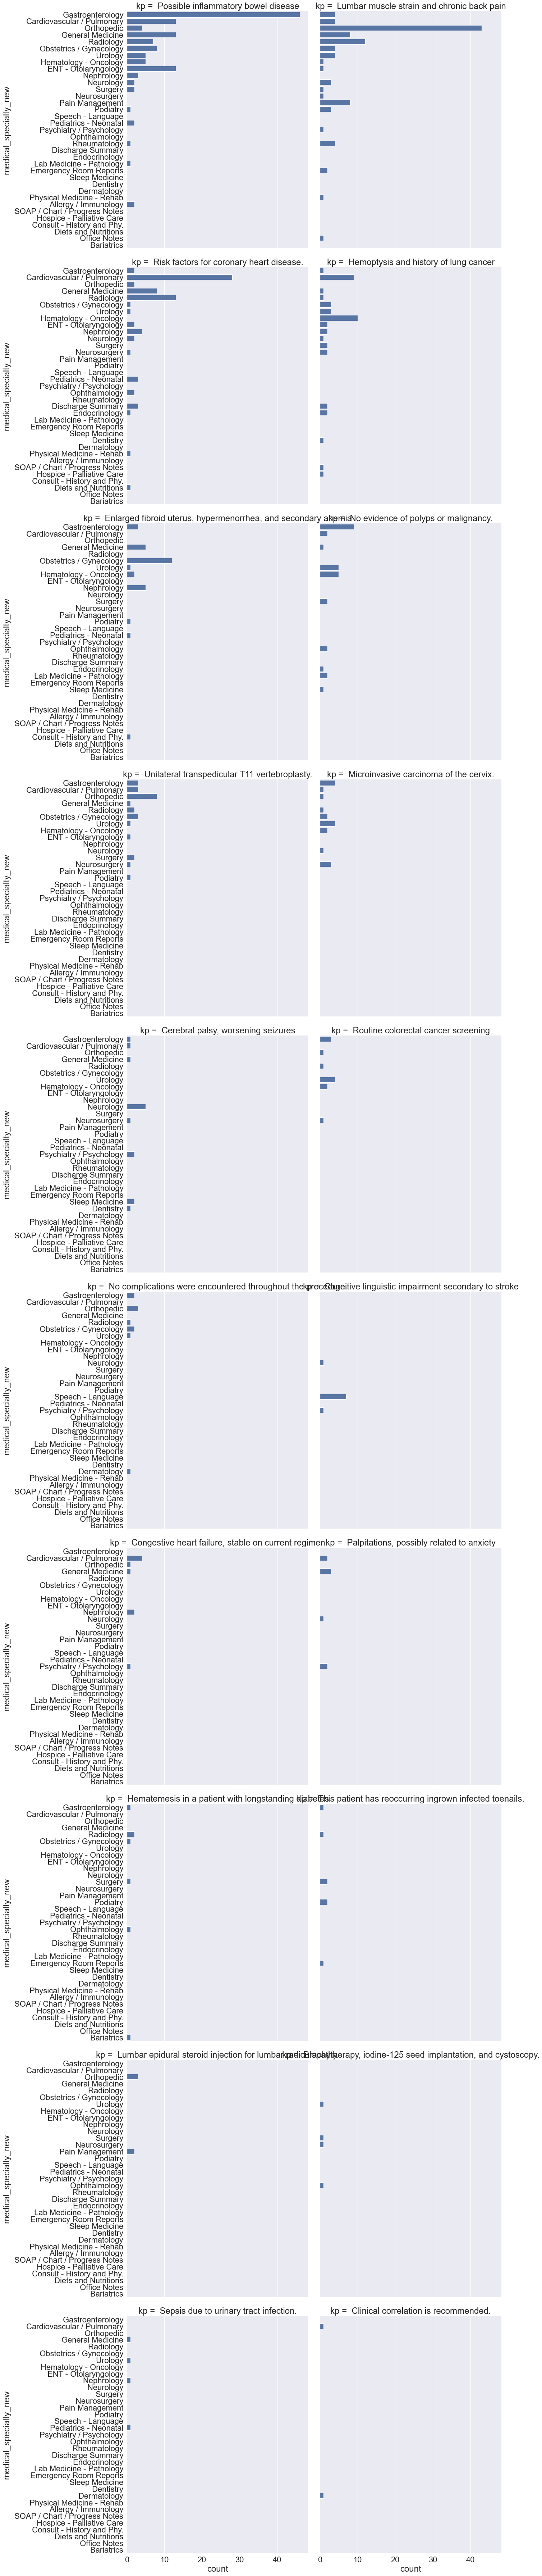

In [17]:
#Distribution of medical specialities for each key point
sns.set(font_scale=2)
g = sns.FacetGrid(df_clean, col="kp", col_wrap=2, height=10)
g.map_dataframe(sns.countplot,
    y="medical_specialty_new",
    data=df_clean,
    order=df_clean["medical_specialty_new"].value_counts().index
);

In [18]:
len(terms)

21

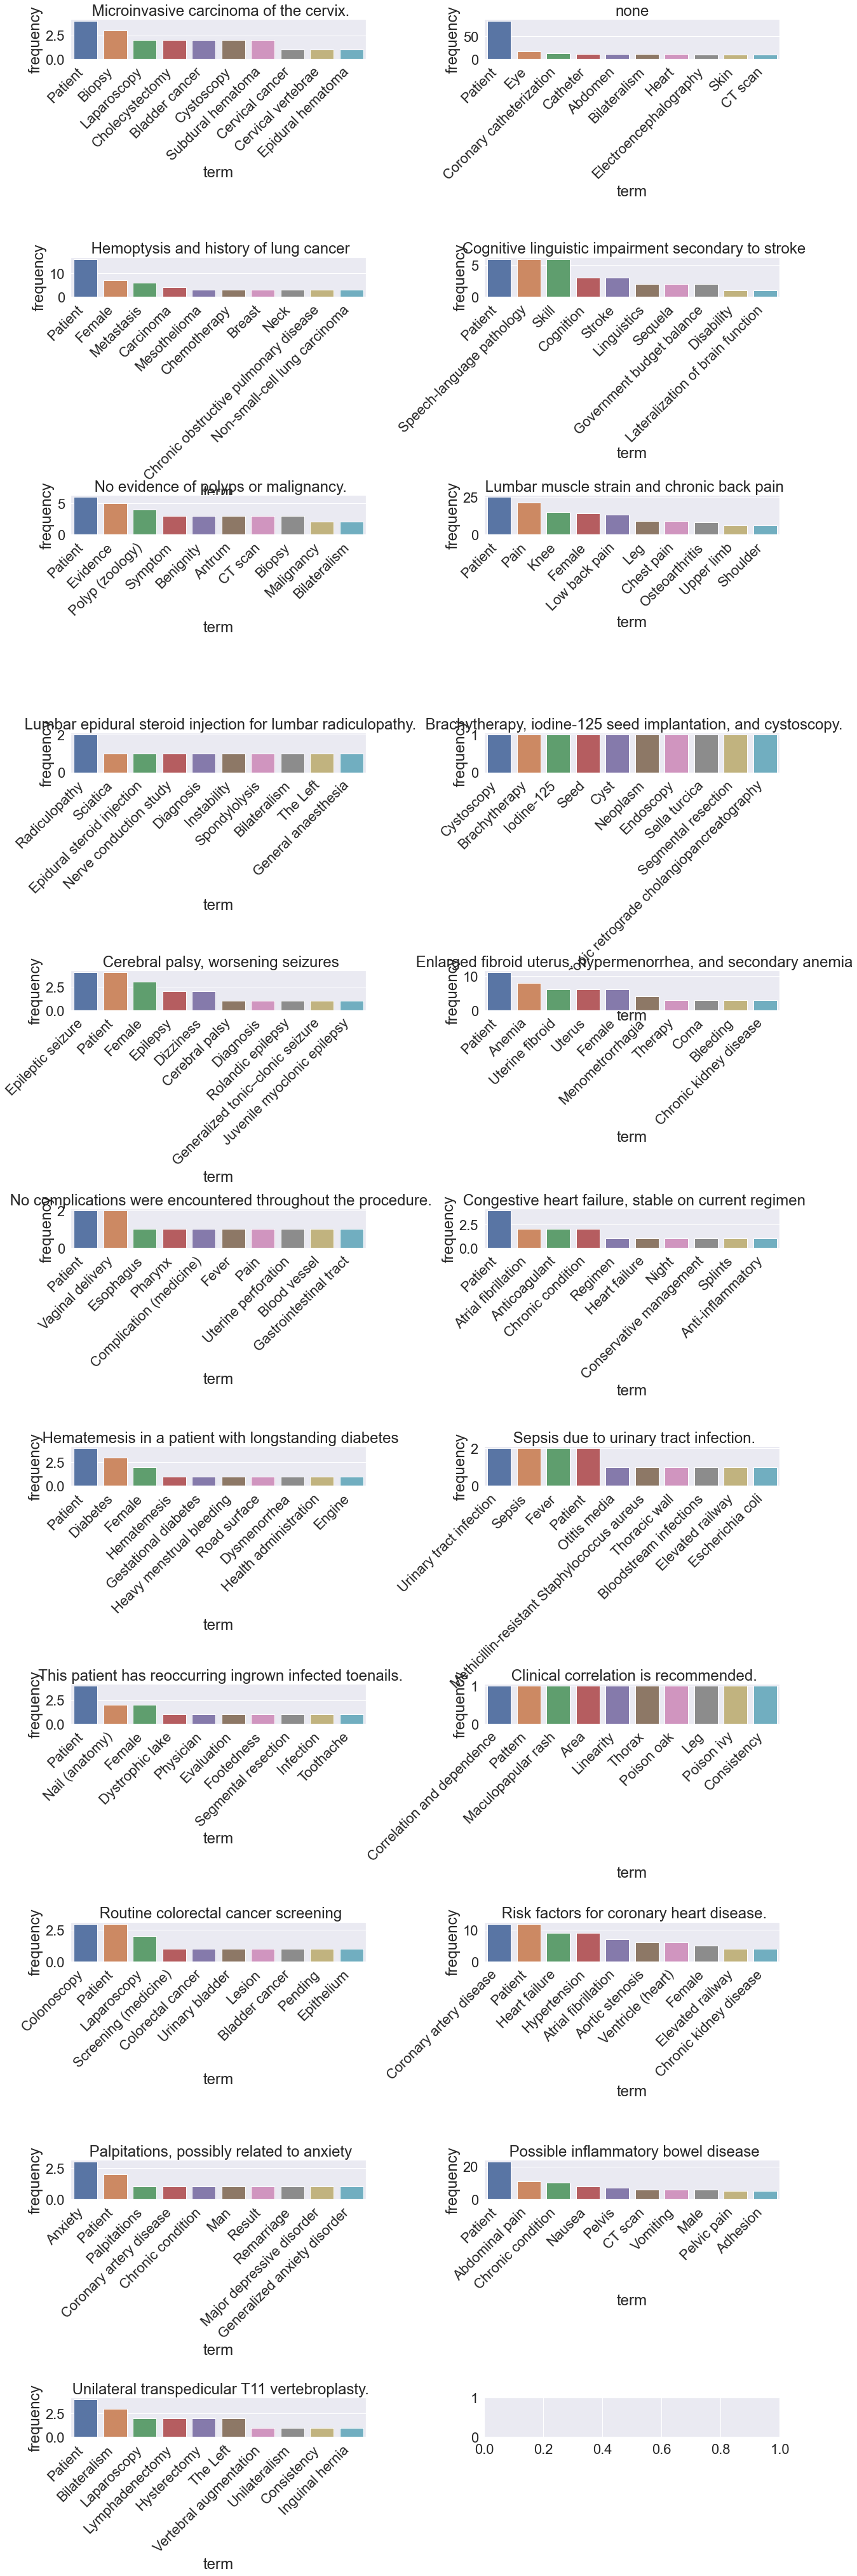

In [19]:
#Top 10 wikipedia terms for each key point
fig, ax = plt.subplots(11, 2, figsize=(20,70))
count = 0
for kp in terms:
    i = count//ax.shape[1]
    j = count-i*ax.shape[1]
    #print(i,j)
    dc = dict(sorted(terms[kp].items(), key= lambda x: x[1], reverse=True)[:10])
    dc_df = pd.DataFrame({"term":dc.keys(), "frequency":dc.values()})
    #display(dc_df)
    sns.barplot(data=dc_df, ax=ax[i,j], x="term",y="frequency").set(title=kp)
    ax[i,j].set_xticklabels(ax[i,j].get_xticklabels(), rotation=45, horizontalalignment='right')
    count += 1

plt.subplots_adjust(wspace=0.4,hspace=5)
    

### 8. Save the data frame to a file

In [20]:
df_clean.to_csv("df_clean.csv", index=False)